## Importing stuff

In [1]:
import sys, os
import tsai
from tsai.all import *
from tsai.imports import *
from tsai.models.layers import *
display(HTML("<style>.container {width:95% !important; }</style>"))

In [2]:
import sys, os
import numpy as np
import pandas as pd
import pickle

In [3]:
sys.path.append(os.path.abspath('../../'))
from utils import utils
from utils.utils import evaluate_experiment
sys.path.append(os.path.abspath('../'))
from timeseries_utils import *
from scipy.fftpack import fft

In [4]:
from fastai import *
from fastai.basic_data import *
from fastai.basic_train import *
from fastai.train import *
from fastai.metrics import *
from fastai.torch_core import *
from fastai.layers import *
from fastai.core import *

## Printing configs

In [5]:
print('tsai       :', tsai.__version__)
print('fastai2    :', fastai2.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)
print('scipy      :', sp.__version__)
print('numpy      :', np.__version__)
print('pandas     :', pd.__version__)
print(f'Total RAM  : {bytes2GB(psutil.virtual_memory().total):5.2f} GB')
print(f'Used RAM   : {bytes2GB(psutil.virtual_memory().used):5.2f} GB')
print('n_cpus     :', cpus)
iscuda = torch.cuda.is_available()
if iscuda: print('device     : {} ({})'.format(device, torch.cuda.get_device_name(0)))
else: print('device     :', device)

tsai       : 0.1.0
fastai2    : 0.0.17
fastcore   : 0.1.18
torch      : 1.5.1
scipy      : 1.5.0
numpy      : 1.18.1
pandas     : 1.0.5
Total RAM  : 62.75 GB
Used RAM   : 16.78 GB
n_cpus     : 16
device     : cuda (GeForce GTX 1080)


## Loading data

In [6]:
path_to_data='../../../'

In [7]:
data=np.load(os.path.abspath(path_to_data+'data-002.npy'),allow_pickle=True)
Y=np.load(path_to_data+'Y.npy',allow_pickle=True)
labels =pd.read_csv(path_to_data+'labels.csv')

In [8]:
train_fold=8
val_fold=9
test_fold=10

# 10th fold for testing (9th for now)
X_test = data[labels.strat_fold == test_fold]
y_test = Y[labels.strat_fold == test_fold]
# 9th fold for validation (8th for now)
X_val = data[labels.strat_fold == val_fold]
y_val = Y[labels.strat_fold == val_fold]
# rest for training
X_train = data[labels.strat_fold <= train_fold]
y_train = Y[labels.strat_fold <= train_fold]

In [9]:
X_train.shape ,X_val.shape

((17111, 1000, 12), (2156, 1000, 12))

In [10]:
# Preprocess signal data
X_train, X_val, X_test = utils.preprocess_signals(X_train, X_val, X_test,'/content/')
n_classes = y_train.shape[1]
# X_train = np.reshape(X_train,[X_train.shape[0],X_train.shape[2],X_train.shape[1]])
# X_val = np.reshape(X_val,[X_val.shape[0],X_val.shape[2],X_val.shape[1]])
X_test = np.reshape(X_test,[X_test.shape[0],X_test.shape[2],X_test.shape[1]])

In [11]:
display(X_train.shape)
_, features, seq_len = X_train.shape

(17111, 1000, 12)

In [12]:
X_train.shape, X_val.shape

((17111, 1000, 12), (2156, 1000, 12))

In [13]:
y_train.shape, y_val.shape

((17111, 5), (2156, 5))

## Get fourier transform

In [14]:
N=1000
X_train_fft = fft(X_train)
X_train_fft = (2/N) * np.abs(X_train_fft)

X_val_fft = fft(X_val)
X_val_fft = (2/N) * np.abs(X_val_fft)

X_train.shape, X_train_fft.shape, X_val_fft.shape, y_train.shape

((17111, 1000, 12), (17111, 1000, 12), (2156, 1000, 12), (17111, 5))

In [15]:
X_train.shape, X_train_fft.shape, X_val_fft.shape, y_train.shape

((17111, 1000, 12), (17111, 1000, 12), (2156, 1000, 12), (17111, 5))

### Concatenate FFT to Train and Val

In [16]:
X_train = np.dstack((X_train,X_train_fft))
X_val = np.dstack((X_val,X_val_fft))

In [17]:
X_train.shape, X_val.shape

((17111, 1000, 24), (2156, 1000, 24))

## Instantiating the model

In [18]:
#export
# This is an unofficial PyTorch implementation by Ignacio Oguiza - oguiza@gmail.com based on:

# Fawaz, H. I., Lucas, B., Forestier, G., Pelletier, C., Schmidt, D. F., Weber, J., ... & Petitjean, F. (2019). 
# InceptionTime: Finding AlexNet for Time Series Classification. arXiv preprint arXiv:1909.04939.
# Official InceptionTime tensorflow implementation: https://github.com/hfawaz/InceptionTime

class _SepConv1d(nn.Module):
    """A simple separable convolution implementation.
    
    The separable convlution is a method to reduce number of the parameters 
    in the deep learning network for slight decrease in predictions quality.
    """
    def __init__(self, ni, no, kernel, stride, pad):
        super().__init__()
        self.depthwise = nn.Conv1d(ni, ni, kernel, stride, padding=pad, groups=ni)
        self.pointwise = nn.Conv1d(ni, no, kernel_size=1)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))

class SepConv1d(nn.Module):
    """Implementes a 1-d convolution with 'batteries included'.
    
    The module adds (optionally) activation function and dropout layers right after
    a separable convolution layer.
    """
    def __init__(self, ni, no, kernel, stride, pad, drop=None,
                 activ=lambda: nn.ReLU(inplace=True)):
    
        super().__init__()
        assert drop is None or (0.0 < drop < 1.0)
        layers = [_SepConv1d(ni, no, kernel, stride, pad)]
        if activ:
            layers.append(activ())
        if drop is not None:
            layers.append(nn.Dropout(drop))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x): 
        return self.layers(x)


class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)
    
def shortcut(c_in, c_out):
    return nn.Sequential(*[nn.Conv1d(c_in, c_out, kernel_size=1), nn.BatchNorm1d(c_out)])
    
    
class Inception(Module):
    def __init__(self, c_in, bottleneck=32, ks=40, nb_filters=32):
        self.bottleneck = nn.Conv1d(c_in, bottleneck, 1) if bottleneck and c_in > 1 else noop
        mts_feat = bottleneck or c_in
        conv_layers = []
        kss = [ks // (2**i) for i in range(3)]
        # ensure odd kss until nn.Conv1d with padding='same' is available in pytorch
        kss = [ksi if ksi % 2 != 0 else ksi - 1 for ksi in kss] 
        for i in range(len(kss)): conv_layers.append(nn.Conv1d(mts_feat, nb_filters, kernel_size=kss[i], padding=kss[i]//2))
        self.conv_layers = nn.ModuleList(conv_layers)
        self.maxpool = nn.MaxPool1d(3, stride=1, padding=1)
        self.conv = nn.Conv1d(c_in, nb_filters, kernel_size=1)
        self.bn = nn.BatchNorm1d(nb_filters * 4)
        self.act = nn.ReLU()

    def forward(self, x):
        input_tensor = x
        x = self.bottleneck(input_tensor)
        for i in range(3):
            out_ = self.conv_layers[i](x)
            if i == 0: out = out_
            else: out = torch.cat((out, out_), 1)
        mp = self.conv(self.maxpool(input_tensor))
        inc_out = torch.cat((out, mp), 1)
        return self.act(self.bn(inc_out))


class InceptionBlock(Module):
    def __init__(self,c_in,bottleneck=32,ks=40,nb_filters=32,residual=True,depth=6):
        self.residual = residual
        self.depth = depth

        #inception & residual layers
        inc_mods = []
        res_layers = []
        res = 0
        for d in range(depth):
            inc_mods.append(Inception(c_in if d == 0 else nb_filters * 4, bottleneck=bottleneck if d > 0 else 0,ks=ks, nb_filters=nb_filters))
            if self.residual and d % 3 == 2:
                res_layers.append(shortcut(c_in if res == 0 else nb_filters * 4, nb_filters * 4))
                res += 1
            else: res_layer = res_layers.append(None)
        self.inc_mods = nn.ModuleList(inc_mods)
        self.res_layers = nn.ModuleList(res_layers)
        self.act = nn.ReLU()
        
    def forward(self, x):
        res = x
        for d, l in enumerate(range(self.depth)):
            x = self.inc_mods[d](x)
            if self.residual and d % 3 == 2:
                res = self.res_layers[d](res)
                x += res
                res = x
                x = self.act(x)
        return x
    
class InceptionTime(Module):
    def __init__(self,c_in,c_in_fft,c_out,bottleneck=32,ks=40,nb_filters=32,residual=True,depth=6, drop=.5):
        self.c_in = c_in
        
        #Main branch
#         self.block = InceptionBlock(c_in, bottleneck=bottleneck, ks=ks, nb_filters=nb_filters, residual=residual, depth=depth)
#         self.gap = nn.AdaptiveAvgPool1d(1)
#         self.squeeze = Squeeze(-1)
        
        #FFT branch
#         self.block = InceptionBlock(c_in, bottleneck=bottleneck, ks=ks, nb_filters=nb_filters, residual=residual, depth=depth)
#         self.gap = nn.AdaptiveAvgPool1d(1)
#         self.squeeze = Squeeze(-1)
        
        #FC
        size_in_fc = (nb_filters * 4) * 2
        self.fc = nn.Linear(size_in_fc, c_out)
        
        self.raw = nn.Sequential(
            InceptionBlock(c_in, bottleneck=bottleneck, ks=ks, nb_filters=nb_filters, residual=residual, depth=depth),
            nn.AdaptiveAvgPool1d(1),
            Squeeze(-1)
        )
        
        self.fft = nn.Sequential(
            InceptionBlock(c_in_fft, bottleneck=bottleneck, ks=ks, nb_filters=nb_filters, residual=residual, depth=depth),
            nn.AdaptiveAvgPool1d(1),
            Squeeze(-1)
        )
        
#         self.fft = nn.Sequential(
#             SepConv1d(c_in_fft,  32, 5, 2, 3, drop=drop),
#             SepConv1d(    32,  64, 5, 4, 2, drop=drop),
#             SepConv1d(    64, 128, 5, 4, 2, drop=drop),
#             SepConv1d(   128, 128, 5, 4, 2, drop=drop),
#             SepConv1d(   128, 256, 5, 4, 2),
#             Flatten(),
#             nn.Dropout(drop), nn.Linear(512, 256), nn.ReLU(inplace=True), # here was 256,64
#             nn.Dropout(drop), nn.Linear(256, 128), nn.ReLU(inplace=True))
                            
    def forward(self, x):
        x, x_fft = torch.split(x, self.c_in, dim=1) # it returns a tuple
        x, x_fft = x.to(device), x_fft.to(device)
        out_raw = self.raw(x)
        out_fft = self.fft(x_fft)
        x = torch.cat([out_raw, out_fft], dim=1)
        x = self.fc(x)
        return x

In [19]:
# utility functions
    
class SqueezeExcite1d(nn.Module):
    '''squeeze excite block as used for example in LSTM FCN'''
    def __init__(self,channels,reduction=16):
        super().__init__()
        channels_reduced = channels//reduction
        self.w1 = torch.nn.Parameter(torch.randn(channels_reduced,channels).unsqueeze(0))
        self.w2 = torch.nn.Parameter(torch.randn(channels, channels_reduced).unsqueeze(0))

    def forward(self, x):
        #input is bs,ch,seq
        z=torch.mean(x,dim=2,keepdim=True)#bs,ch
        intermed = F.relu(torch.matmul(self.w1,z))#(1,ch_red,ch * bs,ch,1) = (bs, ch_red, 1)
        s=F.sigmoid(torch.matmul(self.w2,intermed))#(1,ch,ch_red * bs, ch_red, 1=bs, ch, 1
        return s*x #bs,ch,seq * bs, ch,1 = bs,ch,seq

def weight_init(m):
    '''call weight initialization for model n via n.appy(weight_init)'''
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    if isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight,1)
        nn.init.constant_(m.bias,0)
    if isinstance(m,SqueezeExcite1d):
        stdv1=math.sqrt(2./m.w1.size[0])
        nn.init.normal_(m.w1,0.,stdv1)
        stdv2=math.sqrt(1./m.w2.size[1])
        nn.init.normal_(m.w2,0.,stdv2)

In [20]:
loss = F.binary_cross_entropy_with_logits
input_size=X_train.shape[1]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#batchsize
bs=128
model = InceptionTime(c_in=12,c_in_fft=12,c_out=5).to(device)
X_train_list = [l.astype(np.float32) for l in X_train]
X_val_list = [l.astype(np.float32) for l in X_val]
y_train_list = [l.astype(np.float32) for l in y_train]
y_val_list = [l.astype(np.float32) for l in y_val]

In [21]:
len(X_train), len(X_val)

(17111, 2156)

In [22]:
metrics = [accuracy]
wd=1e-2

chunkify_train=False
chunkify_valid=True
chunk_length_valid=input_size
min_chunk_length=input_size#chunk_length

stride_length_train=input_size#chunk_length_train//8
stride_length_valid=input_size//2#chunk_length_valid


df_train = pd.DataFrame({"data":range(len(X_train_list)),"label":y_train_list})
df_valid = pd.DataFrame({"data":range(len(X_val_list)),"label":y_val_list})

tfms_ptb_xl = [ToTensor()]

ds_train=TimeseriesDatasetCrops(df_train,input_size,num_classes=5,chunk_length= 0,min_chunk_length=min_chunk_length,stride=stride_length_train,transforms=tfms_ptb_xl,annotation=False,col_lbl ="label",npy_data=X_train_list)
ds_valid=TimeseriesDatasetCrops(df_valid,input_size,num_classes=5,chunk_length=chunk_length_valid,min_chunk_length=min_chunk_length,stride=stride_length_valid,transforms=tfms_ptb_xl,annotation=False,col_lbl ="label",npy_data=X_val_list)

db = DataBunch.create(ds_train,ds_valid,bs=bs)
learn = Learner(db,model, loss_func=loss, metrics=metrics,wd=wd,path='/content/models')
learn.model.apply(weight_init)

InceptionTime(
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (raw): Sequential(
    (0): InceptionBlock(
      (inc_mods): ModuleList(
        (0): Inception(
          (conv_layers): ModuleList(
            (0): Conv1d(12, 32, kernel_size=(39,), stride=(1,), padding=(19,))
            (1): Conv1d(12, 32, kernel_size=(19,), stride=(1,), padding=(9,))
            (2): Conv1d(12, 32, kernel_size=(9,), stride=(1,), padding=(4,))
          )
          (maxpool): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
          (conv): Conv1d(12, 32, kernel_size=(1,), stride=(1,))
          (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): ReLU()
        )
        (1): Inception(
          (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
          (conv_layers): ModuleList(
            (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,))
            (1): Conv1d(32, 32, kernel_si

## Training

In [23]:
learn.fit_one_cycle(25,1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.329433,0.422685,0.131169,01:04
1,0.310886,0.373039,0.065028,01:02
2,0.300674,0.418839,0.331911,01:01
3,0.292476,0.328146,0.129963,00:58
4,0.289580,0.325559,0.081633,01:00
5,0.280862,0.331875,0.116327,01:02
6,0.282754,0.611270,0.139889,01:03
7,0.276546,0.309674,0.150371,01:02
8,0.269067,0.304203,0.111596,01:01
9,0.264103,0.300257,0.172542,01:00


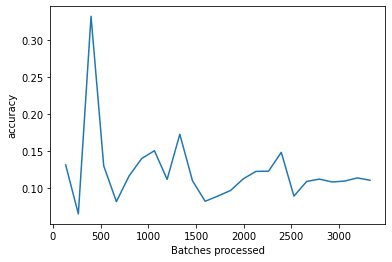

In [24]:
learn.recorder.plot_metrics()

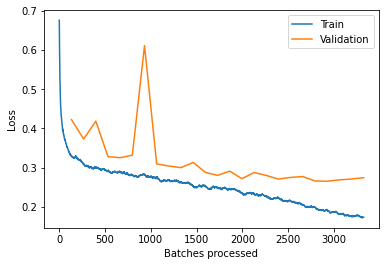

In [25]:
learn.recorder.plot_losses()

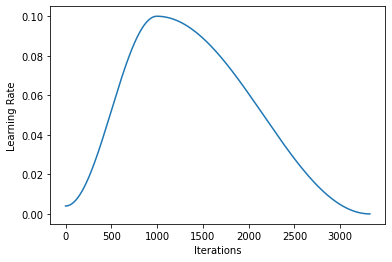

In [26]:
learn.recorder.plot_lr()

## Evaluating

In [27]:
preds,targs=learn.get_preds()
preds = preds.numpy()
targs = targs.numpy()

In [28]:
from utils.utils import evaluate_experiment

In [29]:
%load_ext autoreload
%autoreload 2

In [30]:
thresholds=None
tr_df_point = evaluate_experiment(targs, preds)
print(tr_df_point)

   macro_auc      Fmax
0    0.93255  0.816901


In [31]:
tr_df_point

,macro_auc,Fmax
0,0.93255,0.816901


In [6]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

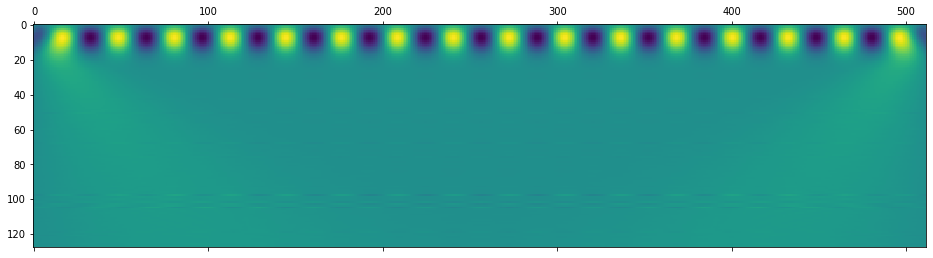

In [8]:

x = np.arange(512)
y = np.sin(2*np.pi*x/32)
coef, freqs=pywt.cwt(y,np.arange(1,129),'gaus1')
plt.matshow(coef) # doctest: +SKIP
plt.show() # doctest: +SKIP


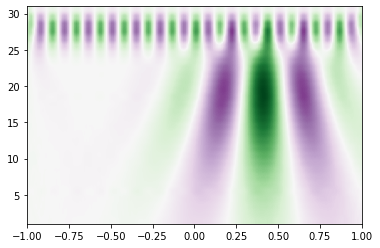

In [10]:
t = np.linspace(-1, 1, 200, endpoint=False)
sig  = np.cos(2 * np.pi * 7 * t) + np.real(np.exp(-7*(t-0.4)**2)*np.exp(1j*2*np.pi*2*(t-0.4)))
widths = np.arange(1, 31)
cwtmatr, freqs = pywt.cwt(sig, widths, 'mexh')
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
plt.show() # doctest: +SKIP